In [5]:
from time import time

import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms

import onlinehd as Onlinehd

SEED = 1234
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(SEED)
torch.manual_seed(SEED)

### Load Function MNIST(Digits), FMNIST, EMNIST(Letters)

In [6]:
# loads simple mnist dataset
def load():
    # fetches data
    x, y = sklearn.datasets.fetch_openml('mnist_784', return_X_y=True)
    x = x.astype(np.float)
    y = y.astype(np.int)
    y = np.array(y)
    print(y)
    # split and normalize
    x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y)
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()

    return x, x_test, y, y_test, scaler

# MNIST

## Normalize

OnlineHD is very sensitive to Normalize.
Therefore, it should be applied

In [4]:
x, x_test, y, y_test, scaler = load()

[5 0 4 ... 4 5 6]


In [7]:
x = x.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

scaler = sklearn.preprocessing.Normalizer().fit(x.reshape(-1, 784))
x = torch.tensor(scaler.transform(x.reshape(-1, 784)))
x_test = torch.tensor(scaler.transform(x_test.reshape(-1, 784)))

In [14]:
print(type(y))
print(x.shape)
classes = y.unique().size(0)
print(y.unique())
features = x.size(1)
print(features)
model = Onlinehd.OnlineHD(classes, features, dim=10000)

if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
print(x.shape)
model = model.fit(x, y, bootstrap=1.0, lr=0.035, epochs=20)
t = time() - t

<class 'torch.Tensor'>
torch.Size([52500, 784])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
784
Training...
torch.Size([52500, 784])


KeyboardInterrupt: 

In [8]:
print('Validating...')
yhat = model(x)
yhat_test = model(x_test)
acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')

Validating...
acc = 0.945410
acc_test = 0.935429
t = 22.263634


# Generate FGSM

In [8]:
def fgsm_attack(x_original, epsilon, gradient):
    # Get Gradient sign
    grad_sign = gradient.sign()
    # Add epsilon*grad_sign perturbation to the original input
    perturbation = epsilon*grad_sign
    x_perturbed = x_original + perturbation
    return x_perturbed, perturbation

In [9]:
import torch.nn as nn
import time

epsilons = torch.Tensor([0.01, 0.03, 0.07, 0.1])
acc_results_non = dict()
verbose = False
criterion = nn.CosineEmbeddingLoss()
N_VAL_SAMPLES = x_test.data.shape[0]

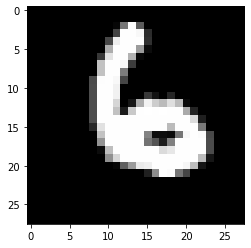

In [10]:
plt.imshow(x_test[-1].reshape(28, 28), cmap='gray')

100%|█████████████████████████████████████| 17500/17500 [02:59<00:00, 97.59it/s]


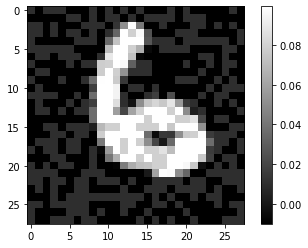


FGSM Attack with epsilon = 0.01000 | Elapsed time: 179.50 seconds.
Accuracy: Before the attack -> 93.54%	|	After the attack -> 91.54%


100%|████████████████████████████████████| 17500/17500 [02:48<00:00, 103.63it/s]


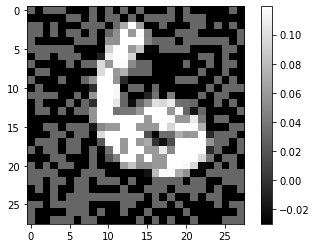


FGSM Attack with epsilon = 0.03000 | Elapsed time: 169.03 seconds.
Accuracy: Before the attack -> 93.54%	|	After the attack -> 27.53%


100%|████████████████████████████████████| 17500/17500 [02:45<00:00, 105.88it/s]


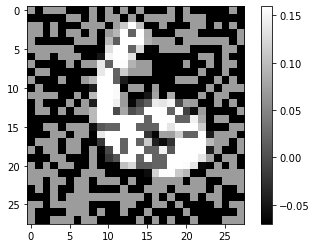


FGSM Attack with epsilon = 0.07000 | Elapsed time: 165.42 seconds.
Accuracy: Before the attack -> 93.54%	|	After the attack -> 9.14%


100%|████████████████████████████████████| 17500/17500 [02:39<00:00, 109.42it/s]


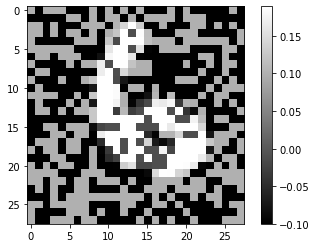


FGSM Attack with epsilon = 0.10000 | Elapsed time: 160.12 seconds.
Accuracy: Before the attack -> 93.54%	|	After the attack -> 9.02%


In [13]:
from tqdm import tqdm

attack_sample = {'0.01':torch.zeros(17500, 28, 28),
                 '0.03':torch.zeros(17500, 28, 28),
                 '0.07':torch.zeros(17500, 28, 28),
                 '0.1':torch.zeros(17500, 28, 28)}

for eps in epsilons:
    correct_unperturbed = 0
    correct_perturbed = 0
    t0 = time.perf_counter()

    attack = torch.zeros(17500, 28, 28)
    labels = torch.zeros(17500)
    for j in tqdm(range(len(x_test))):
    ### NOTE: IT WOULD BE MORE EFFICIENT TO ITERATE ONLY ONCE THROUGH THE DATA AND PERFORM ALL THE ATTACKS
        x_origin, y_target = x_test[j], y_test[j]
        x_origin, y_target = x_origin.to(device), y_target.to(device)
        x_origin.requires_grad = True

        y_pred = model(x_origin.reshape(-1, 784))
        
        if y_pred == y_target:
            correct_unperturbed += 1
            
        label = torch.ones(classes, dtype=int) * -1
        label[y_target.item()] = 1
        # Calculate loss and gradient
        output = model.encode(x_origin.reshape(-1, 784))
        loss = criterion(output, model.model, label)
        grad = torch.autograd.grad(outputs=loss, inputs=x_origin)[0]

        perturbed_x, _ = fgsm_attack(x_origin, epsilon=eps, gradient=grad)
        perturbed_output = model(perturbed_x.reshape(-1, 784))            

        if perturbed_output == y_target:
            correct_perturbed += 1
        
        attack[j] = perturbed_x.reshape(28, 28)
        labels[j] = y_target
        
    if eps == 0.1:
        attack_sample['0.1'] = attack
    elif eps == 0.07:
        attack_sample['0.07'] = attack
    elif eps == 0.03:
        attack_sample['0.03'] = attack
    else:
        attack_sample['0.01'] = attack                
        
    plt.imshow(perturbed_x.detach().numpy().reshape(28, 28), cmap='gray')
    plt.colorbar()
    plt.show()
    acc_before_attack = correct_unperturbed / N_VAL_SAMPLES
    acc_after_attack = correct_perturbed / N_VAL_SAMPLES
    print(f'\nFGSM Attack with epsilon = {eps:.5f} | Elapsed time: {time.perf_counter() - t0:.2f} seconds.')
    print(f'Accuracy: Before the attack -> {100 * acc_before_attack:.2f}%\t|\tAfter the attack -> {100 * acc_after_attack:.2f}%')
    acc_results_non[eps.item()] = acc_after_attack
acc_results_non[0] = acc_before_attack

In [14]:
import pickle 

data = {'data' : attack_sample,
        'label' : labels}

with open('MNIST_FGSM_HD.pickle', 'wb') as f:
    pickle.dump(data, f)

In [15]:
for eps in attack_sample.keys():
    attack_norm = attack_sample[eps].detach().numpy().reshape(-1, 784)
    attack_norm = scaler.transform(attack_norm)
    attack_sample[eps] = torch.from_numpy(attack_norm).float()

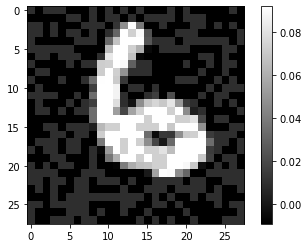

In [16]:
plt.imshow(attack_sample['0.01'][-1].reshape(28, 28), cmap='gray')
plt.colorbar()

In [17]:
print('Validating...')
yhat = model(x)
yhat_test = model(x_test)
yhat_attack_001 = model(attack_sample['0.01'])
yhat_attack_003 = model(attack_sample['0.03'])
yhat_attack_007 = model(attack_sample['0.07'])
yhat_attack_010 = model(attack_sample['0.1'])

acc = (y == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
acc_attack_001 = (labels == yhat_attack_001).float().mean()
acc_attack_003 = (labels == yhat_attack_003).float().mean()
acc_attack_007 = (labels == yhat_attack_007).float().mean()
acc_attack_010 = (labels == yhat_attack_010).float().mean()

print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{acc_attack_001 = :6f}')
print(f'{acc_attack_003 = :6f}')
print(f'{acc_attack_007 = :6f}')
print(f'{acc_attack_010 = :6f}')

Validating...
acc = 0.945410
acc_test = 0.935429
acc_attack_001 = 0.920343
acc_attack_003 = 0.832457
acc_attack_007 = 0.420971
acc_attack_010 = 0.301771
